# Vehicle Detection with Detectron2

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_Vehicle_Detection.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_Vehicle_Detection.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 21.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=5890b830267c46f392012c39d69b6105bdbd41cd825138a560dcb4902fa52946
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 749kB/s 
     |████████████████████████████████| 2.2MB 18.8MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for iopath: filename=iopath-0.1.6-cp37-none-any.whl size=18269 sha256=9a6fdfe62e5e7199fa847360fd6e223f527ff74961b63e38d32f459f9d948d01
  Stored in directory: /root/.cache/pip/wheels/ff/87/55/7513122394822977f993e1798bfebb46730d6183df8db7b283
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210311-cp37-none-any.whl size=58461 sha256=07937044a1ddeefb8fe65d9c98b98596db392f3d642d9bca8ad7fc2aa7827a67
  Stored in directory: /root/.cache/pip/wheels/bc/cc/93/e011d6b86d91631d948f9bda94d60b82b51302192eb8a688c8
Successfully built iopath fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

## Get data

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
!wget https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!wget https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv

--2021-03-15 19:17:47--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.12.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.12.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: ‘object-detection-crowdai.tar.gz’

object-detection-cr 100%[===================>]   1.54G  44.6MB/s    in 33s     

2021-03-15 19:18:20 (47.4 MB/s) - ‘object-detection-crowdai.tar.gz’ saved [1650810880/1650810880]

--2021-03-15 19:18:20--  https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7156250 (6.8M) [text/plain

In [3]:
!tar xf object-detection-crowdai.tar.gz

In [4]:
import pandas as pd

df = pd.read_csv('labels_crowdai.csv')

df.head()

xmin  ymin  ...  Label                                        Preview URL
0   785   533  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1    89   551  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2   268   546  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3   455   522  ...  Truck  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4   548   522  ...  Truck  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...

[5 rows x 7 columns]

## Register data-set

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)

    classes = df['Label'].unique().tolist()

    df['class_int'] = df['Label'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for idx, filename in enumerate(df['filename'].unique().tolist()):
        record = {}
        
        #height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 1200
        record["width"] = 1920

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = df['Label'].unique().tolist()

DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')

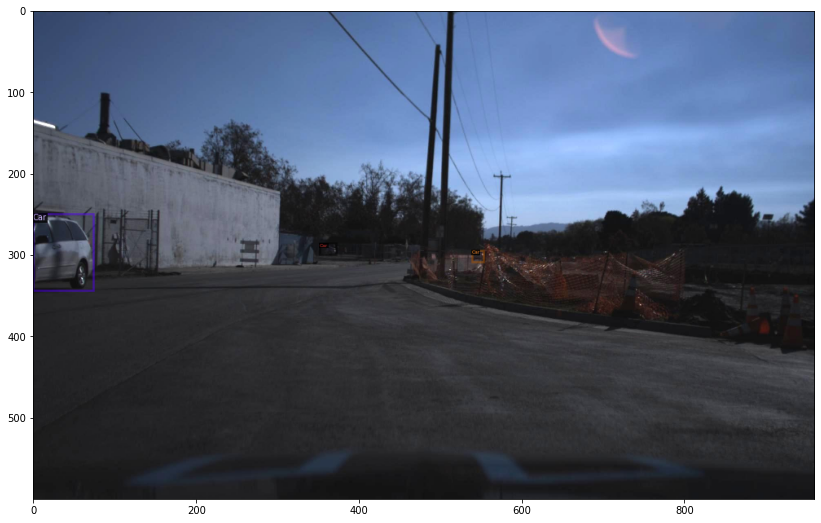

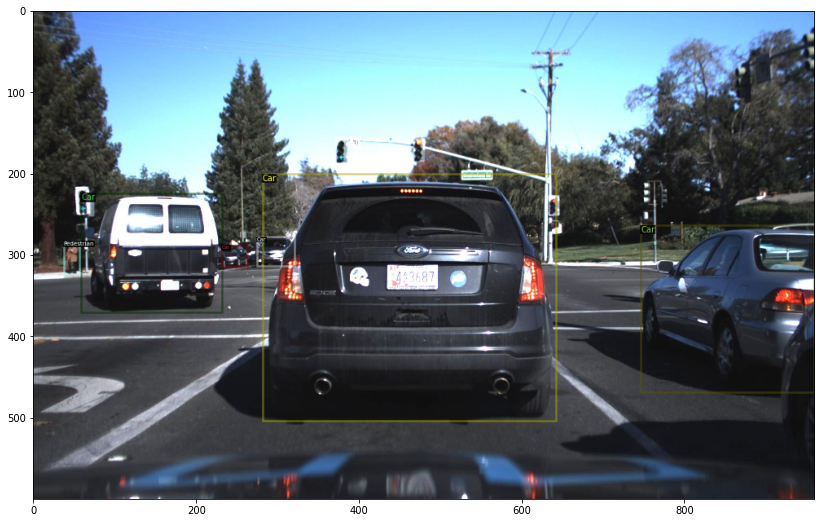

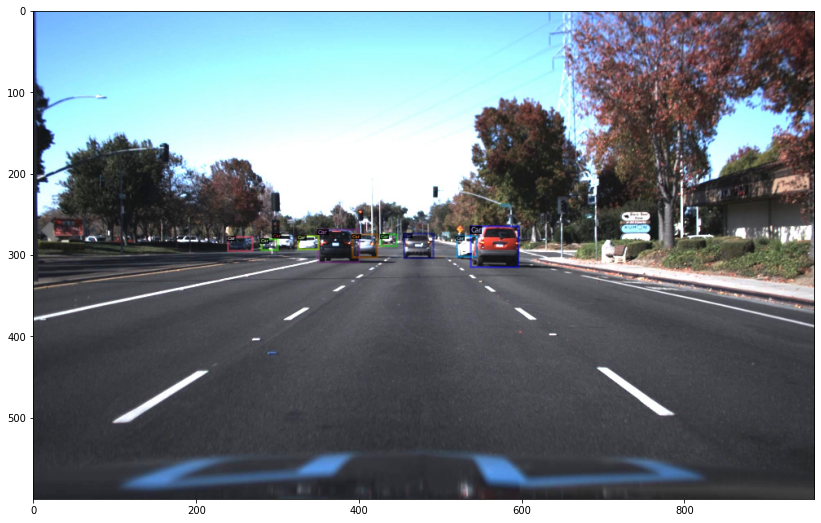

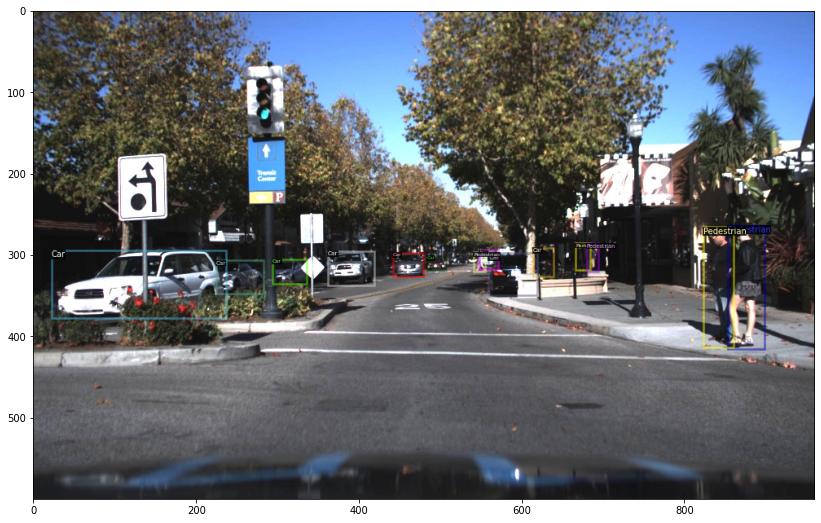

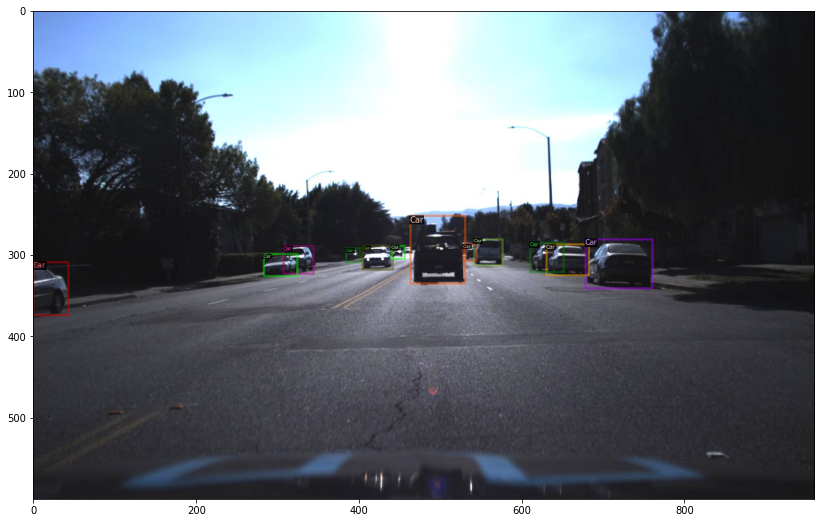

In [7]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('crowdai_vehicle_detection',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/15 19:19:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:09, 25.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[03/15 19:20:35 d2.engine.train_loop]: Starting training from iteration 0
[03/15 19:20:49 d2.utils.events]:  eta: 0:10:50  iter: 19  total_loss: 1.842  loss_cls: 1.154  loss_box_reg: 0.7112  loss_rpn_cls: 0.02752  loss_rpn_loc: 0.04651  time: 0.6520  data_time: 0.0233  lr: 0.00039962  max_mem: 3665M
[03/15 19:21:03 d2.utils.events]:  eta: 0:11:02  iter: 39  total_loss: 1.083  loss_cls: 0.3777  loss_box_reg: 0.605  loss_rpn_cls: 0.0247  loss_rpn_loc: 0.03967  time: 0.6678  data_time: 0.0059  lr: 0.00079922  max_mem: 3665M
[03/15 19:21:16 d2.utils.events]:  eta: 0:10:47  iter: 59  total_loss: 0.8293  loss_cls: 0.2653  loss_box_reg: 0.5341  loss_rpn_cls: 0.01575  loss_rpn_loc: 0.03941  time: 0.6739  data_time: 0.0074  lr: 0.0011988  max_mem: 3665M
[03/15 19:21:30 d2.utils.events]:  eta: 0:10:32  iter: 79  total_loss: 0.6667  loss_cls: 0.2226  loss_box_reg: 0.3625  loss_rpn_cls: 0.009609  loss_rpn_loc: 0.03794  time: 0.6722  data_time: 0.0057  lr: 0.0015984  max_mem: 3665M
[03/15 19:21:44 

## Use model for inference

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

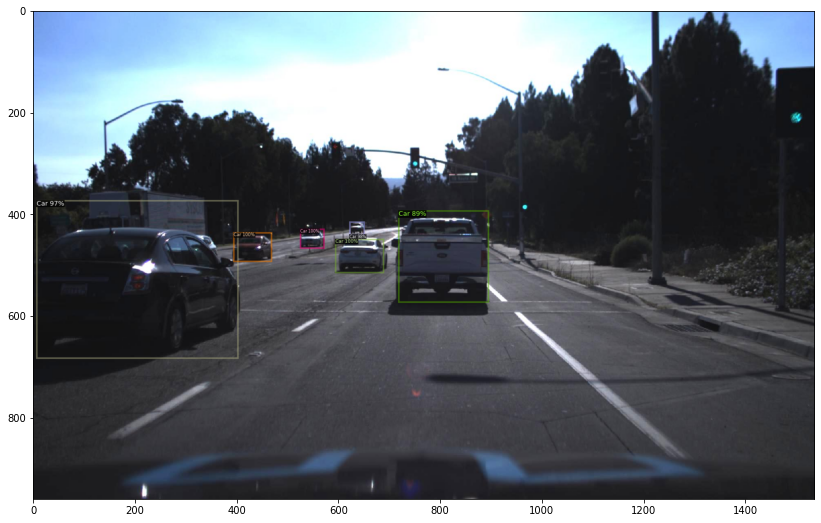

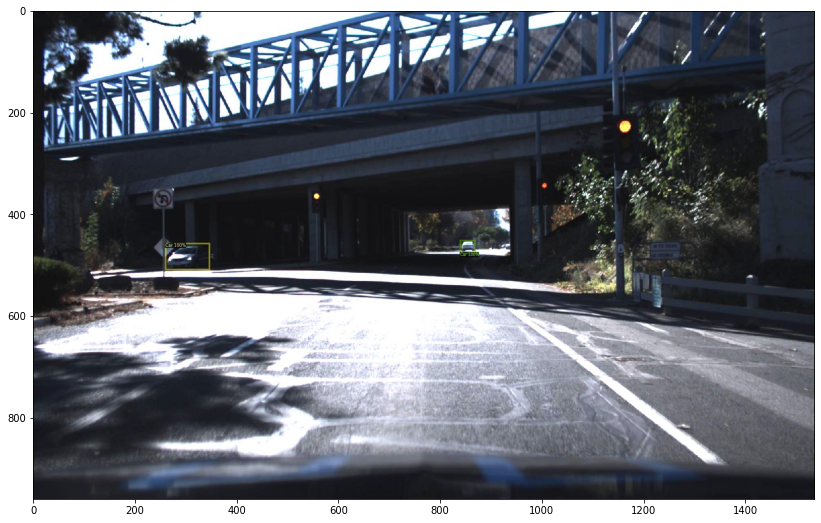

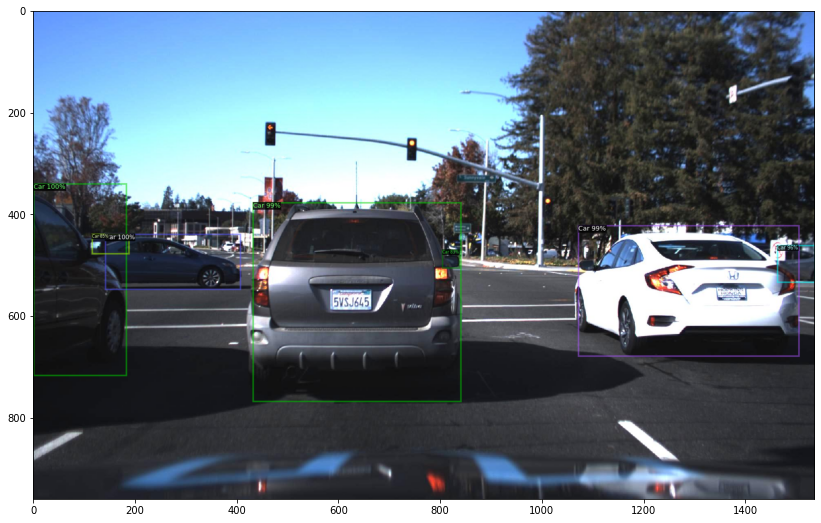

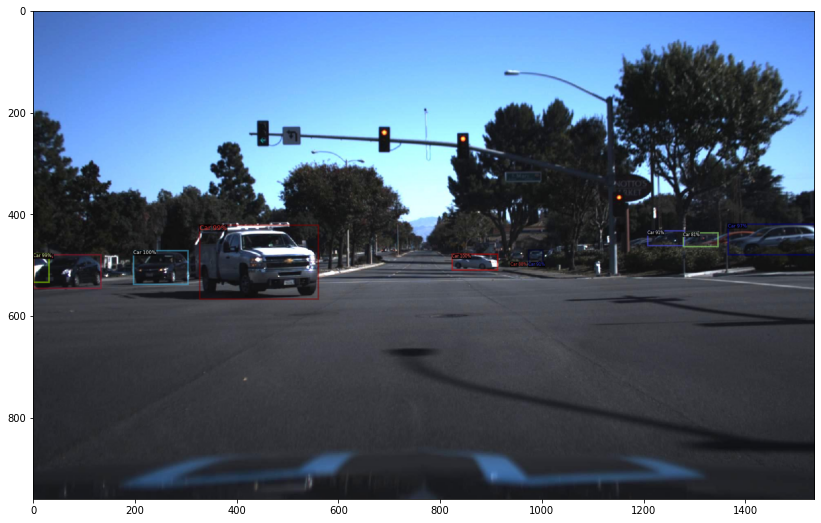

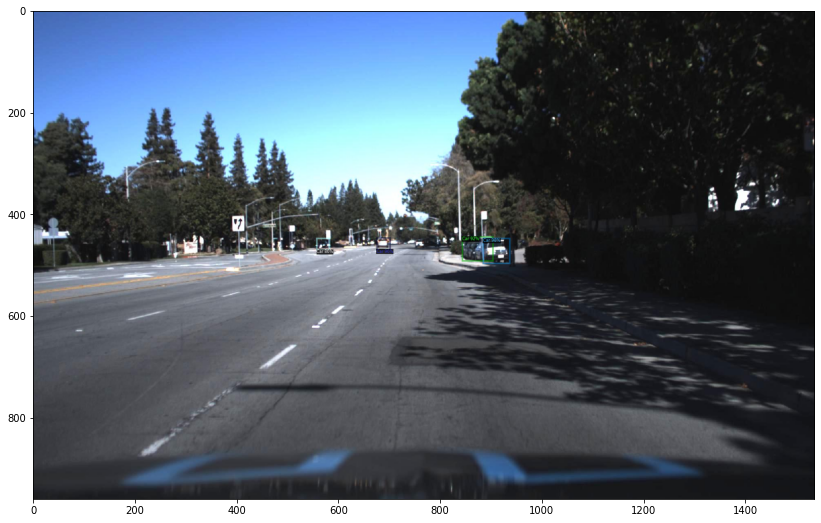

In [10]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()